In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
# Load FC

import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
lowrankdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/PNC/Top10/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))
no_snps_subs = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/fc_subs_no_snps.pkl', 'rb'))

rest = []
nback = []
emoid = []
restmat = []
nbackmat = []
emoidmat = []
race = []
sex = []
age = []
subids = []

a,b = np.triu_indices(264,1)

for sub in pncdemo['age_at_cnb']:
    if sub in no_snps_subs:
        continue
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        n = np.load(f'{pncdir}/fc/{sub}_task-nback_fc.npy')
        e = np.load(f'{pncdir}/fc/{sub}_task-emoid_fc.npy')
        r = remap(vec2mat(r))
        n = remap(vec2mat(n))
        e = remap(vec2mat(e))
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r[a,b])
        nback.append(n[a,b])
        emoid.append(e[a,b])
        subids.append(sub)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

print([a.shape for a in [rest, nback, emoid, race, sex, age]])

[(1155, 34716), (1155, 34716), (1155, 34716), (1155,), (1155,), (1155,)]


In [3]:
# Load big SNPs

snps = []
no_snps_subs = []

snps_file = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/snps_all_subs_big.pkl', 'rb'))

for sub in subids:
    if sub not in snps_file:
        print(sub)
        # no_snps_subs.append(sub)
    snps.append(snps_file[sub])

snps = np.stack(snps)
snps[np.isnan(snps)] = 0

print(snps.shape)

(1155, 35621)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

class SNPVAE(nn.Module):
    def __init__(self, snpd, ld):
        super(SNPVAE, self).__init__()
        self.ld = ld
        self.enc1 = nn.Linear(snpd*3, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+2, 1000).float().cuda()
        self.dec20 = nn.Linear(1000, snpd).float().cuda()
        self.dec21 = nn.Linear(1000, snpd).float().cuda()
        self.dec22 = nn.Linear(1000, snpd).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)

    def dec(self, z, sex, race):
        z = torch.cat([z, sex.unsqueeze(1), race.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x0 = self.dec20(x)
        x1 = self.dec21(x)
        x2 = self.dec22(x)
        return torch.stack([x0, x1, x2], dim=1)

def latent_loss(z):
    C = z.T@z
    mu = torch.mean(z, dim=0)
    tgt1 = torch.eye(z.shape[-1]).float().cuda()*len(z)/10
    tgt2 = torch.zeros(z.shape[-1]).float().cuda()
    lossC = rmse(C, tgt1)
    lossmu = rmse(mu, tgt2)
    return lossC, lossmu, C, mu

def decor_loss(z, sex, race):
    sex = sex - torch.mean(sex)
    race = race - torch.mean(race)
    sexp = torch.einsum('n,nz->z', sex, z)
    racep = torch.einsum('n,nz->z', race, z)
    tgt = torch.zeros(z.shape[-1]).float().cuda()
    loss_sex = rmse(sexp, tgt)
    loss_race = rmse(racep, tgt)
    return loss_sex + loss_race

ce = nn.CrossEntropyLoss()

# snpvae = SNPVAE(10433, 30)
snpvae = SNPVAE(35621, 100)
snpvae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_snps_big_1000_z100_cov2.torch'))
snpvae.eval()

xclass = torch.from_numpy(snps).long().cuda()
x = torch.cat([xclass == 0, xclass == 1, xclass == 2], dim=1).float().cuda()
sex_t = torch.from_numpy(sex).float().cuda()
race_t = torch.from_numpy(race).float().cuda()

print('Done')

Done


In [5]:
with torch.no_grad():
    z = snpvae.enc(x)
    logits = snpvae.dec(z, sex_t, race_t)
    xhat = torch.argmax(logits, dim=1)

for i in range(800,1000):
    print(torch.sum(xhat[i] == xclass[i]))
print(xhat[2])
print(xclass[2])

tensor(33629, device='cuda:0')
tensor(29759, device='cuda:0')
tensor(35621, device='cuda:0')
tensor(33496, device='cuda:0')
tensor(35327, device='cuda:0')
tensor(35504, device='cuda:0')
tensor(35431, device='cuda:0')
tensor(34295, device='cuda:0')
tensor(33910, device='cuda:0')
tensor(35308, device='cuda:0')
tensor(29521, device='cuda:0')
tensor(35581, device='cuda:0')
tensor(35425, device='cuda:0')
tensor(34509, device='cuda:0')
tensor(32095, device='cuda:0')
tensor(32433, device='cuda:0')
tensor(34485, device='cuda:0')
tensor(35492, device='cuda:0')
tensor(35406, device='cuda:0')
tensor(35494, device='cuda:0')
tensor(35621, device='cuda:0')
tensor(35478, device='cuda:0')
tensor(33117, device='cuda:0')
tensor(35364, device='cuda:0')
tensor(32256, device='cuda:0')
tensor(31379, device='cuda:0')
tensor(31255, device='cuda:0')
tensor(32366, device='cuda:0')
tensor(30948, device='cuda:0')
tensor(31583, device='cuda:0')
tensor(34977, device='cuda:0')
tensor(35475, device='cuda:0')
tensor(3

In [6]:
class VAE(nn.Module):
    def __init__(self, fcd, ld):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, fcd).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        return x

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(34716, 30)
vae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_1000_z30_cov6.torch'))
vae.eval()

print('Done')

Done


In [7]:
vec = []

with torch.no_grad():
    z = snpvae.gen(len(x))
    sx = torch.randint(high=2,size=[len(z)]).float().cuda()
    rc = torch.randint(high=2,size=[len(z)]).float().cuda()
    logits = snpvae.dec(z, sex_t, rc)
    xhat = torch.argmax(logits, dim=1)
    for j in range(len(x)):
        sm = int(torch.sum(xclass[j] == xhat[j]))
        vec.append(sm)

vec = np.array(vec)*100/35621
print(np.mean(vec),np.std(vec))

49.8212020707178 4.177271036214808


In [30]:
vec = []

for i in range(len(xclass)):
    idcs = np.random.permutation(len(xclass))
    j = 0
    while race_t[idcs[j]] != race_t[i]:# or sex_t[idcs[j]] != sex_t[i]:
        j += 1
    sm = int(torch.sum(xclass[i] == xclass[idcs[j]]))
    vec.append(sm)

vec = np.array(vec)*100/35621
print(np.mean(vec),np.std(vec))

52.27884810883604 1.8978918156007392


In [94]:
class FCToSNP(nn.Module):
    def __init__(self, ldfc, ldsnp):
        super(FCToSNP, self).__init__()
        self.fc1 = nn.Linear(ldfc, 1000).float().cuda()
        self.fc2 = nn.Linear(1000, ldsnp).float().cuda()

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = self.fc2(z)
        return z

fc2snp = FCToSNP(30, 100)
optim = torch.optim.Adam(fc2snp.parameters(), lr=1e-4, weight_decay=1e-4)

with torch.no_grad():
    zrest = vae.enc(torch.from_numpy(rest).float().cuda())
    znback = vae.enc(torch.from_numpy(nback).float().cuda())
    zemoid = vae.enc(torch.from_numpy(emoid).float().cuda())
    zsnp = snpvae.enc(x)

nepochs = 30000
pperiod = 500

for e in range(nepochs):
    optim.zero_grad()
    if e % 3 == 0:
        z = zrest[:800]
    elif e % 3 == 1:
        z = znback[:800]
    else:
        z = zemoid[:800]
    zhat = fc2snp(z)
    loss = rmse(zhat, zsnp[:800])
    loss.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss)}')

print('Done')

0 1.1894
500 1.1362
1000 1.0889
1500 1.0526
2000 1.0165
2500 0.987
3000 0.9776
3500 0.9531
4000 0.9332
4500 0.9325
5000 0.9121
5500 0.8957
6000 0.8982
6500 0.8798
7000 0.8654
7500 0.8688
8000 0.8519
8500 0.8387
9000 0.8424
9500 0.8274
10000 0.8148
10500 0.8183
11000 0.8052
11500 0.7933
12000 0.796
12500 0.7845
13000 0.7737
13500 0.7755
14000 0.7654
14500 0.7557
15000 0.7561
15500 0.7474
16000 0.7389
16500 0.7379
17000 0.7308
17500 0.7231
18000 0.721
18500 0.7153
19000 0.7085
19500 0.7051
20000 0.7009
20500 0.6949
21000 0.6901
21500 0.6877
22000 0.6821
22500 0.6762
23000 0.6752
23500 0.6701
24000 0.6632
24500 0.6635
25000 0.659
25500 0.6512
26000 0.6527
26500 0.6489
27000 0.6399
27500 0.6424
28000 0.6394
28500 0.6295
29000 0.6328
29500 0.6304
29999 0.6267
Done


53.95043515634668 1.9272071866144977


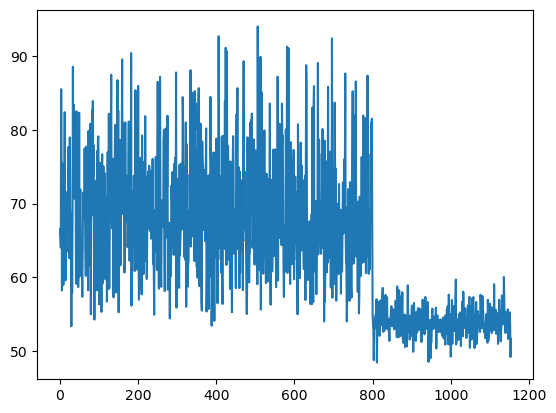

In [97]:
import matplotlib.pyplot as plt

vec = []

with torch.no_grad():
    zhat1 = fc2snp(zrest)
    zhat2 = fc2snp(znback)
    zhat3 = fc2snp(zemoid)
    zhat = (zhat1+zhat2+zhat3)/3
    sx = torch.randint(high=2,size=[len(zrest)]).float().cuda()
    rc = torch.randint(high=2,size=[len(zrest)]).float().cuda()
    logits = snpvae.dec(zhat2, sex_t, race_t)
    xhat = torch.argmax(logits, dim=1)
    for j in range(len(zhat)):
        sm = int(torch.sum(xclass[j] == xhat[j]))
        vec.append(sm)

vec = np.array(vec)
vec = 100*vec/35621
print(np.mean(vec[800:]), np.std(vec[800:]))
plt.plot(vec)
plt.show()

In [89]:
from sklearn.cluster import KMeans

vec = []

miss = np.random.permutation(35621)[:100]
test = snps[800:]+0
test[:,miss] = 0 #np.random.uniform(low=0,high=3,size=(len(test),len(miss)))
kmeans = KMeans(n_clusters=8).fit(snps[:800])
cls = kmeans.predict(test)
for i in range(len(cls)):
    cl = kmeans.cluster_centers_[cls[i]]
    cl = np.round(cl)
    sm = np.sum(snps[200+i] == cl)*100/35621
    vec.append(sm)

print(np.mean(vec), np.std(vec))

/usr/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


56.565651453427336 4.221510142372041


In [90]:
class Similarity(nn.Module):
    def __init__(self, ldfc, ldsnp):
        super(Similarity, self).__init__()
        self.fca1 = nn.Linear(ldfc, 5).float().cuda()
        self.fcb1 = nn.Linear(ldsnp, 5).float().cuda()
        self.fc2 = nn.Linear(10, 1).float().cuda()

    def forward(self, zfc, zsnp):
        zfc = F.relu(self.fca1(zfc))
        zsnp = F.relu(self.fcb1(zsnp))
        z = torch.cat([zfc, zsnp], dim=1)
        z = self.fc2(z)
        return z

def cl_loss(sims, pidcs, tau):
    pp = sims[pidcs]
    ep = torch.sum(torch.exp(pp/tau))
    en = torch.sum(torch.exp(sims/tau))
    loss = -torch.log(ep/en)
    return loss

sim = Similarity(30, 100)
optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4)

with torch.no_grad():
    zrest = vae.enc(torch.from_numpy(rest).float().cuda())
    znback = vae.enc(torch.from_numpy(nback).float().cuda())
    zemoid = vae.enc(torch.from_numpy(emoid).float().cuda())
    zsnp = snpvae.enc(x)

nepochs = 10000
pperiod = 500
nb = 100

for e in range(nepochs):
    optim.zero_grad()
    sidcs = np.random.permutation(len(x))[:nb]
    idcs1 = []
    idcs2 = []
    pidcs = []
    for i in range(nb):
        idcs1.append(np.ones(nb)*sidcs[i])
        idcs2.append(sidcs)
        pidcs.append(nb*i+i)
    idcs1 = np.array(np.concatenate(idcs1))
    idcs2 = np.array(np.concatenate(idcs2))
    pidcs = np.array(pidcs)
    if e % 3 == 0:
        ztask = zrest
    elif e % 3 == 1:
        ztask = znback
    else:
        ztask = zemoid
    sims = sim(ztask[idcs1], zsnp[idcs2])
    loss_cl = cl_loss(sims, pidcs, 1)
    loss_cl.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss_cl)}')

print('Complete')

0 4.605
500 4.5996
1000 4.5378
1500 4.4885
2000 4.5236
2500 4.2858
3000 4.0584
3500 4.2803
4000 3.7965
4500 3.922
5000 4.2076
5500 4.5183
6000 4.0161
6500 3.011
7000 4.691
7500 4.4055
8000 4.9787
8500 3.1883
9000 3.4111
9500 3.3217
9999 2.8559
Complete


In [93]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

nsamp = 100
vec = len(zrest)*[None]

for i in range(len(zrest)):
    with torch.no_grad():
        z = snpvae.gen(nsamp)
        simr = sim(zrest[i:i+1].repeat([nsamp,1]), z)
        simn = sim(znback[i:i+1].repeat([nsamp,1]), z)
        sime = sim(zemoid[i:i+1].repeat([nsamp,1]), z)
        # print(torch.cat([simr, simn, sime], dim=1))
        ss = simr+simn+sime
        ss = ss.squeeze()
        idcs = torch.argsort(ss, descending=True)
        # print(ss[idcs])
        logits = snpvae.dec(z[idcs], torch.ones(nsamp).float().cuda()*sex_t[i], torch.ones(nsamp).float().cuda()*race_t[i])
        xhat = torch.argmax(logits, dim=1)
        vec[i] = int(torch.sum(xclass[i] == xhat[0]))*100/35621
    if i % 50 == 0:
        print(f'Done {i}')
        # for j in range(nsamp):
        #     vec[j] = int(torch.sum(xclass[i] == xhat[j]))

print(np.mean(vec))
# plt.plot(vec)
# plt.plot(savgol_filter(np.array(vec),51,3))
# plt.show()

Done 0
Done 50
Done 100
Done 150
Done 200
Done 250
Done 300
Done 350
Done 400
Done 450
Done 500
Done 550
Done 600
Done 650
Done 700
Done 750
Done 800
Done 850
Done 900
Done 950
Done 1000
Done 1050
Done 1100
Done 1150
53.47878233704011
